<a href="https://colab.research.google.com/github/inoueshinji8/PythonStudy/blob/main/chainertest1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#https://chainer-colab-notebook.readthedocs.io/ja/latest/notebook/hands_on/chainer/begginers_hands_on/00_How_to_use_chainer_on_colaboratory.html
#を参照する


!curl https://colab.chainer.org/install | sh -

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1580  100  1580    0     0   5448      0 --:--:-- --:--:-- --:--:--  5448
+ apt -y -q install cuda-libraries-dev-10-0
Reading package lists...
Building dependency tree...
Reading state information...
cuda-libraries-dev-10-0 is already the newest version (10.0.130-1).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.
+ pip install -q cupy-cuda100  chainer 
     |████████████████████████████████| 58.9 MB 1.3 MB/s 
     |████████████████████████████████| 1.0 MB 40.6 MB/s 
+ set +ex
Installation succeeded!


In [2]:
!python -c 'import chainer; chainer.print_runtime_info()'

/usr/local/lib/python3.7/dist-packages/chainer/_environment_check.py:75: UserWarning: 
--------------------------------------------------------------------------------
CuPy (cupy-cuda111) version 9.4.0 may not be compatible with this version of Chainer.
Please consider installing the supported version by running:
  $ pip install 'cupy-cuda111>=7.7.0,<8.0.0'

See the following page for more details:
  https://docs.cupy.dev/en/latest/install.html
--------------------------------------------------------------------------------

  requirement=requirement, help=help))
/usr/local/lib/python3.7/dist-packages/chainer/_environment_check.py:75: UserWarning: 
--------------------------------------------------------------------------------
CuPy (cupy-cuda100) version 9.6.0 may not be compatible with this version of Chainer.
Please consider installing the supported version by running:
  $ pip install 'cupy-cuda100>=7.7.0,<8.0.0'

See the following page for more details:
  https://docs.cupy.dev/en/l

In [3]:
!apt -y -qq install graphviz > /dev/null 2> /dev/null
!pip install pydot

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import chainer

/usr/local/lib/python3.7/dist-packages/chainer/_environment_check.py:75: UserWarning: 
--------------------------------------------------------------------------------
CuPy (cupy-cuda111) version 9.4.0 may not be compatible with this version of Chainer.
Please consider installing the supported version by running:
  $ pip install 'cupy-cuda111>=7.7.0,<8.0.0'

See the following page for more details:
  https://docs.cupy.dev/en/latest/install.html
--------------------------------------------------------------------------------

  requirement=requirement, help=help))


In [6]:
LABEL_NAMES = [
    'T-shirt/top',
    'Trouser',
    'Pullover',
    'Dress',
    'Coat',
    'Sandal',
    'Shirt',
    'Sneaker',
    'Bag',
    'Ankle boot'
]

def get_label_name(label):
    return LABEL_NAMES[label]

In [7]:
for i in range(len(LABEL_NAMES)):
    print(i, ' is ', get_label_name(i))

0  is  T-shirt/top
1  is  Trouser
2  is  Pullover
3  is  Dress
4  is  Coat
5  is  Sandal
6  is  Shirt
7  is  Sneaker
8  is  Bag
9  is  Ankle boot


In [8]:
from chainer.datasets.fashion_mnist import get_fashion_mnist

# データセットがダウンロード済みでなければ、ダウンロードも行う
train, test = get_fashion_mnist(withlabel=True, ndim=1)

In [9]:
print('Size of train', len(train))
print('Size of test', len(test))

Size of train 60000
Size of test 10000


In [10]:
x, t = test[0]
print('Shape of x:', x.shape)
print('label:', t)
print('label name:', get_label_name(t))

Shape of x: (784,)
label: 9
label name: Ankle boot


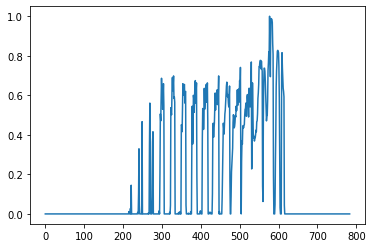

In [11]:
plt.plot(x)

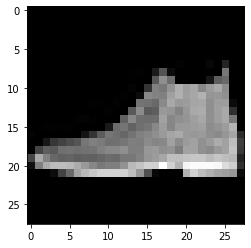

In [12]:
plt.imshow(x.reshape(28, 28), cmap='gray')

0 T-shirt/top


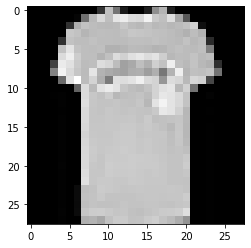

1 Trouser


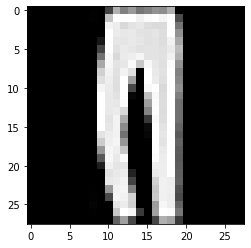

2 Pullover


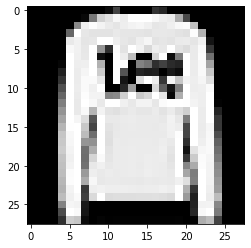

3 Dress


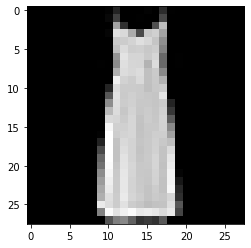

4 Coat


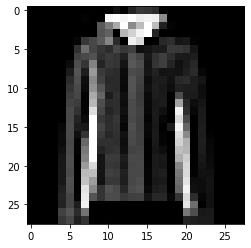

5 Sandal


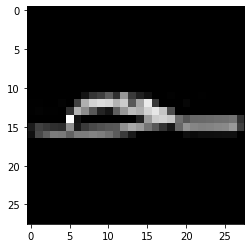

6 Shirt


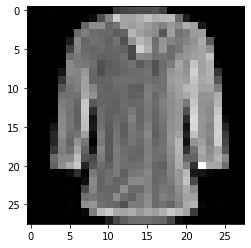

7 Sneaker


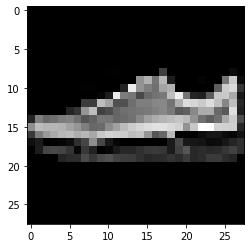

8 Bag


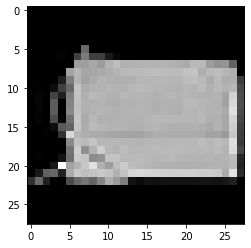

9 Ankle boot


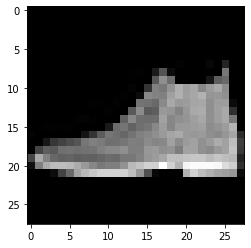

In [13]:
for label_name in LABEL_NAMES:
    this_data = ((x,t) for x, t in test if get_label_name(t) == label_name)  # generator
    x, t = next(this_data)
    print(t, label_name)
    plt.imshow(x.reshape(28, 28), cmap='gray')
    plt.show()

In [14]:
train, validation = chainer.datasets.split_dataset_random(train, 50000, seed=0)

In [15]:
import chainer.functions as F
import chainer.links as L
from chainer import Chain

class MLP2(Chain):

    # Initialization of layers
    def __init__(self):
        super(MLP2, self).__init__()
        with self.init_scope():
            self.l1=L.Linear(784, 200)  # From 784-dimensional input to hidden unit with 200 nodes
            self.l2=L.Linear(200, 10)  # From hidden unit with 200 nodes to output unit with 10 nodes  (10 classes)

    # Forward computation
    def forward(self, x):
        h1 = F.tanh(self.l1(x))  # Forward from x to h1 through activation with tanh function
        y = self.l2(h1)  # Forward from h1to y
        return y

In [16]:
from chainer import optimizers, training
from chainer.training import extensions

def  train_and_validate(
        model, optimizer, train, validation, n_epoch, batchsize, device):

    # 1. deviceがgpuであれば、gpuにモデルのデータを転送する
    if device >= 0:
        model.to_gpu(device)

    # 2. Optimizerを設定する
    optimizer.setup(model)

    # 3. DatasetからIteratorを作成する
    train_iter = chainer.iterators.SerialIterator(train, batchsize)
    validation_iter = chainer.iterators.SerialIterator(
        validation, batchsize, repeat=False, shuffle=False)

    # 4. Updater・Trainerを作成する
    updater = training.StandardUpdater(train_iter, optimizer, device=device)
    trainer = chainer.training.Trainer(updater, (n_epoch, 'epoch'), out='out')

    # 5. Trainerの機能を拡張する
    trainer.extend(extensions.LogReport())
    trainer.extend(extensions.Evaluator(validation_iter, model, device=device), name='val')
    trainer.extend(extensions.PrintReport(
        ['epoch', 'main/loss', 'main/accuracy', 'val/main/loss', 'val/main/accuracy', 'elapsed_time']))
    trainer.extend(extensions.PlotReport(
        ['main/loss', 'val/main/loss'],x_key='epoch', file_name='loss.png'))
    trainer.extend(extensions.PlotReport(
        ['main/accuracy', 'val/main/accuracy'], x_key='epoch', file_name='accuracy.png'))
    trainer.extend(extensions.dump_graph('main/loss'))

    # 6. 訓練を開始する
    trainer.run()

In [17]:
device = -1  # specify gpu id. if device == -1, use cpu
n_epoch = 5  # Only 5 epochs
batchsize = 256

model = MLP2() # MLP2 model
classifier_model = L.Classifier(model)
optimizer = optimizers.SGD()

In [18]:
train_and_validate(
    classifier_model, optimizer, train, validation, n_epoch, batchsize, device)

epoch       main/loss   main/accuracy  val/main/loss  val/main/accuracy  elapsed_time
1           1.44567     0.596979       1.06002        0.681445           3.19315       
2           0.921152    0.717308       0.848792       0.723926           6.48502       
3           0.783225    0.752624       0.755695       0.75166            9.6866        
4           0.711036    0.772939       0.700316       0.766309           12.9006       
5           0.663995    0.785196       0.662144       0.77793            16.1273       


In [20]:
import pydot
from IPython.display import Image, display

def show_graph():
    graph = pydot.graph_from_dot_file('out/cg.dot') # load from .dot file
    graph[0].write_png('graph.png')
    display(Image('graph.png', width=600, height=600))

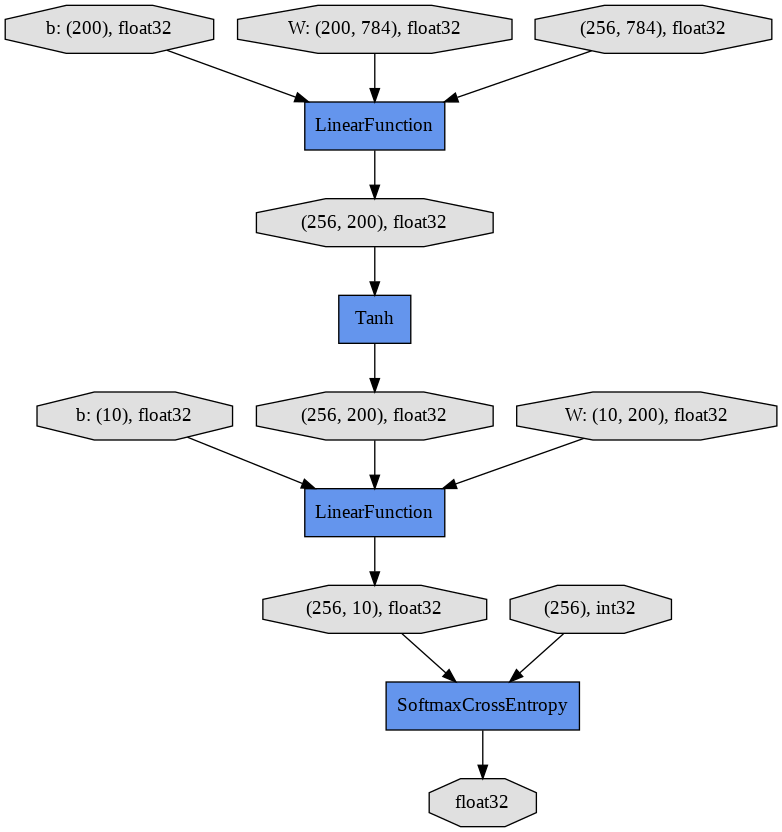

In [21]:
show_graph()

In [22]:
def show_loss_and_accuracy():
    display(Image(filename='out/loss.png'))
    display(Image(filename='out/accuracy.png'))

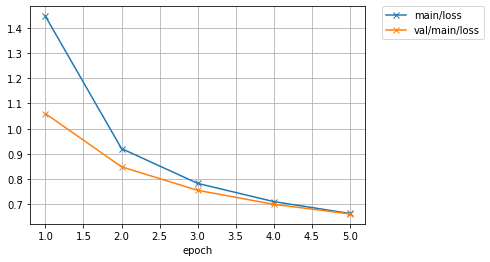

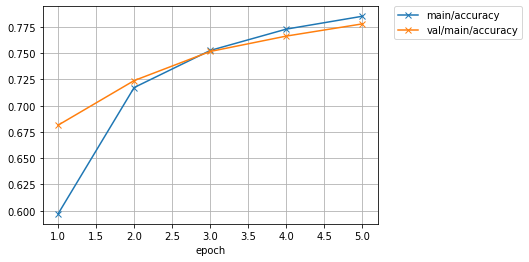

In [23]:
show_loss_and_accuracy()

In [24]:
from chainer import Variable

def show_examples(model, test, device):
    plt.figure(figsize=(12,50))
    if device >= 0:
        model.to_cpu()
    for i in range(45, 105):
        data, label = test[i]  # test data, label
        x = Variable(np.asarray([data]))
        t = Variable(np.asarray([label]))  # labels
        y = model(x)
        prediction = y.data.argmax(axis=1)
        example = (data * 255).astype(np.int32).reshape(28, 28)
        plt.subplot(20, 5, i - 44)
        plt.imshow(example, cmap='gray')
        plt.title("No.{0}\nAnswer:{1}\nPredict:{2}".format(
            i,
            get_label_name(label),
            get_label_name(prediction[0])
        ))
        plt.axis("off")
    plt.tight_layout()

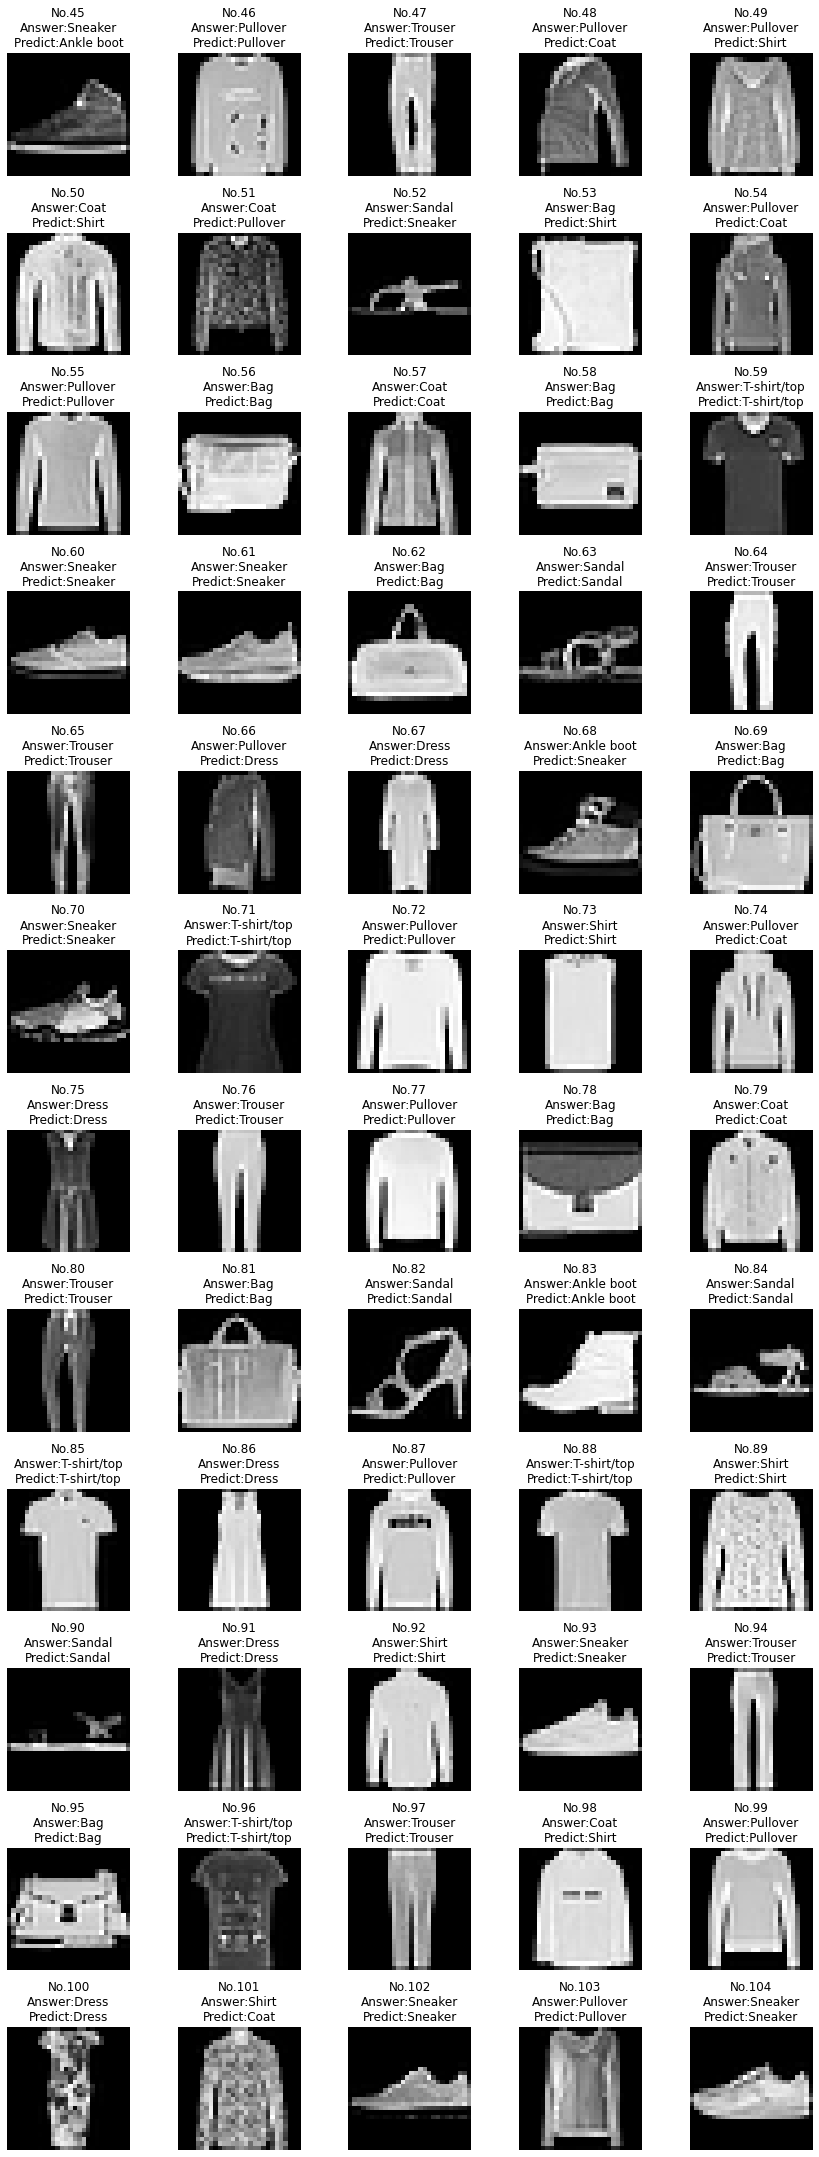

In [25]:
show_examples(model, test, device)

In [26]:
def show_test_performance(model, test, device, batchsize=256):
    if device >=0:
        model.to_gpu()
    test_iter = chainer.iterators.SerialIterator(
        test, batchsize, repeat=False, shuffle=False
    )
    test_evaluator = extensions.Evaluator(test_iter, model, device=device)
    results = test_evaluator()
    print('Test accuracy:', results['main/accuracy'])

In [27]:
show_test_performance(classifier_model, test, device)

Test accuracy: 0.77880859375


In [28]:
device = 0
n_epoch = 5
batchsize = 256

model = MLP2()
classifier_model = L.Classifier(model)
optimizer = optimizers.SGD()
train_and_validate(
    classifier_model, optimizer, train, validation, n_epoch, batchsize, device)

epoch       main/loss   main/accuracy  val/main/loss  val/main/accuracy  elapsed_time
1           1.42933     0.607063       1.04827        0.692871           9.73866       
2           0.916815    0.723658       0.841408       0.730762           11.304        
3           0.780615    0.755949       0.750456       0.756934           12.91         
4           0.709376    0.774593       0.695566       0.768848           14.5377       
5           0.662842    0.788742       0.659306       0.778613           16.1535       


In [29]:
## 3-layer multi-Layer Perceptron (MLP)
class MLP3(Chain):

    def __init__(self):
        super(MLP3, self).__init__()
        with self.init_scope():
            self.l1=L.Linear(784, 200)
            self.l2=L.Linear(200, 200)   # Additional  layer
            self.l3=L.Linear(200, 10)

    def forward(self, x):
        h1 = F.tanh(self.l1(x))   # Hidden unit 1
        h2 = F.tanh(self.l2(h1)) # Hidden unit 2
        y = self.l3(h2)
        return y

In [30]:
device = 0
n_epoch = 5
batchsize = 256

model = MLP3()  # Use MLP3 instead of MLP2
classifier_model = L.Classifier(model)
optimizer = optimizers.SGD()
train_and_validate(
    classifier_model, optimizer, train, validation, n_epoch, batchsize, device)

epoch       main/loss   main/accuracy  val/main/loss  val/main/accuracy  elapsed_time
1           1.39868     0.607502       1.00335        0.678906           1.7428        
2           0.874115    0.715104       0.801976       0.730176           3.61172       
3           0.741096    0.754808       0.712993       0.764551           5.46724       
4           0.669992    0.778898       0.657125       0.775293           7.34903       
5           0.622097    0.793129       0.618769       0.787402           9.22008       


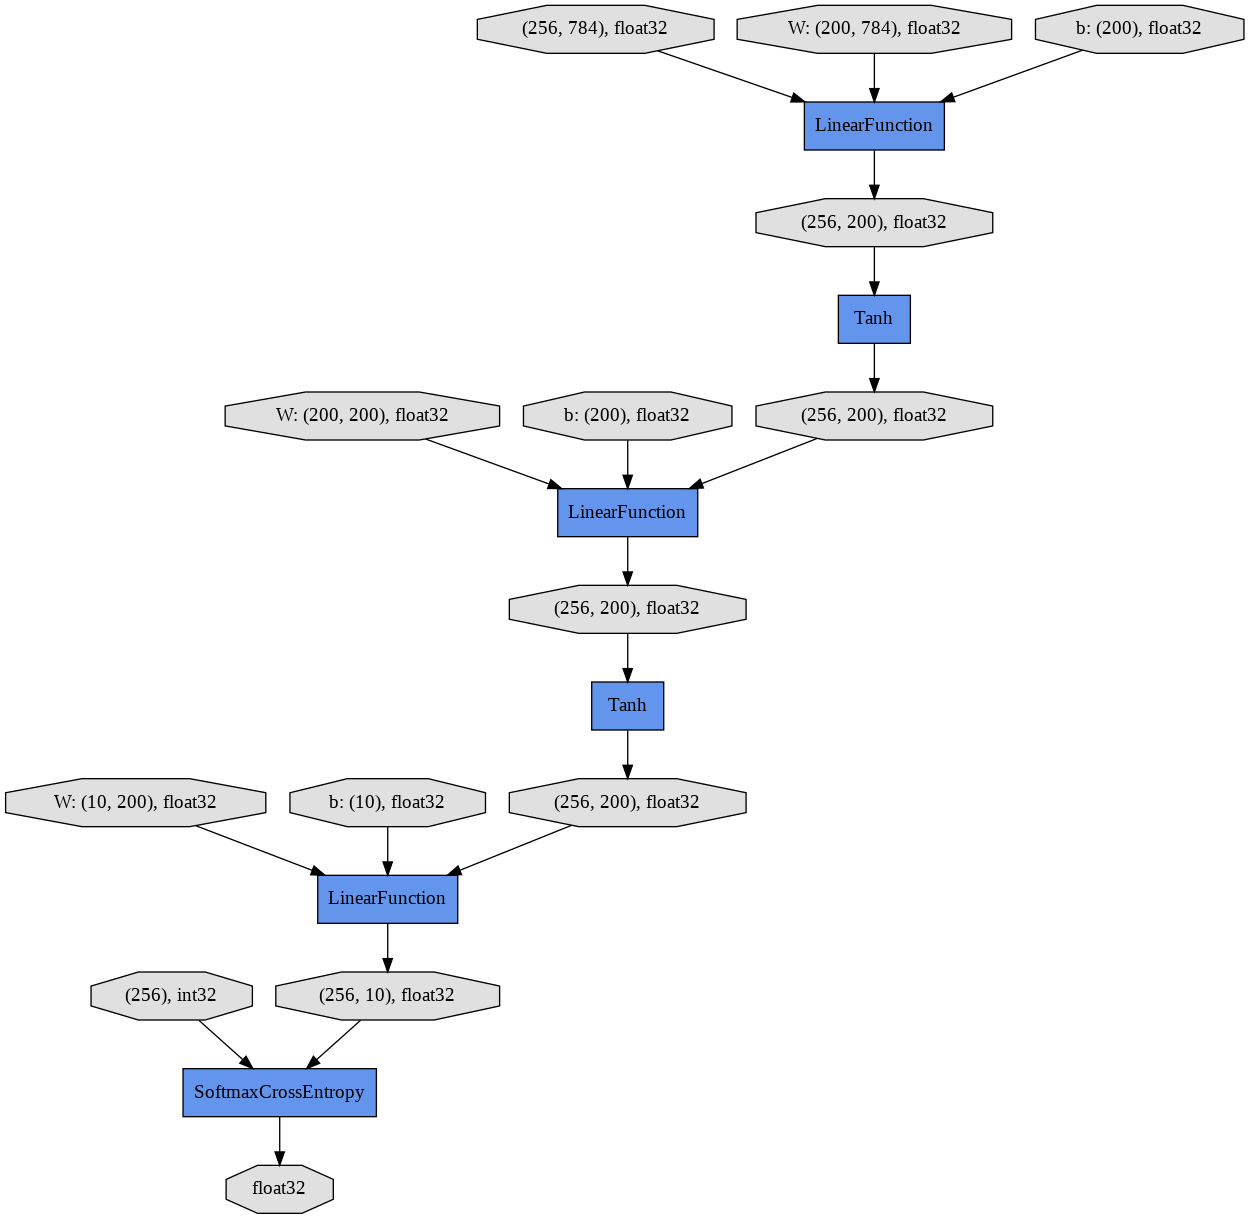

In [31]:
show_graph()

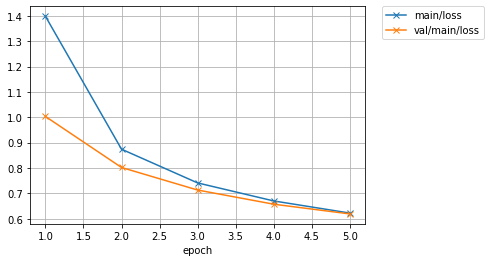

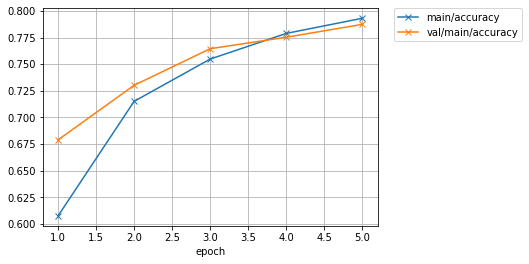

In [32]:
show_loss_and_accuracy()

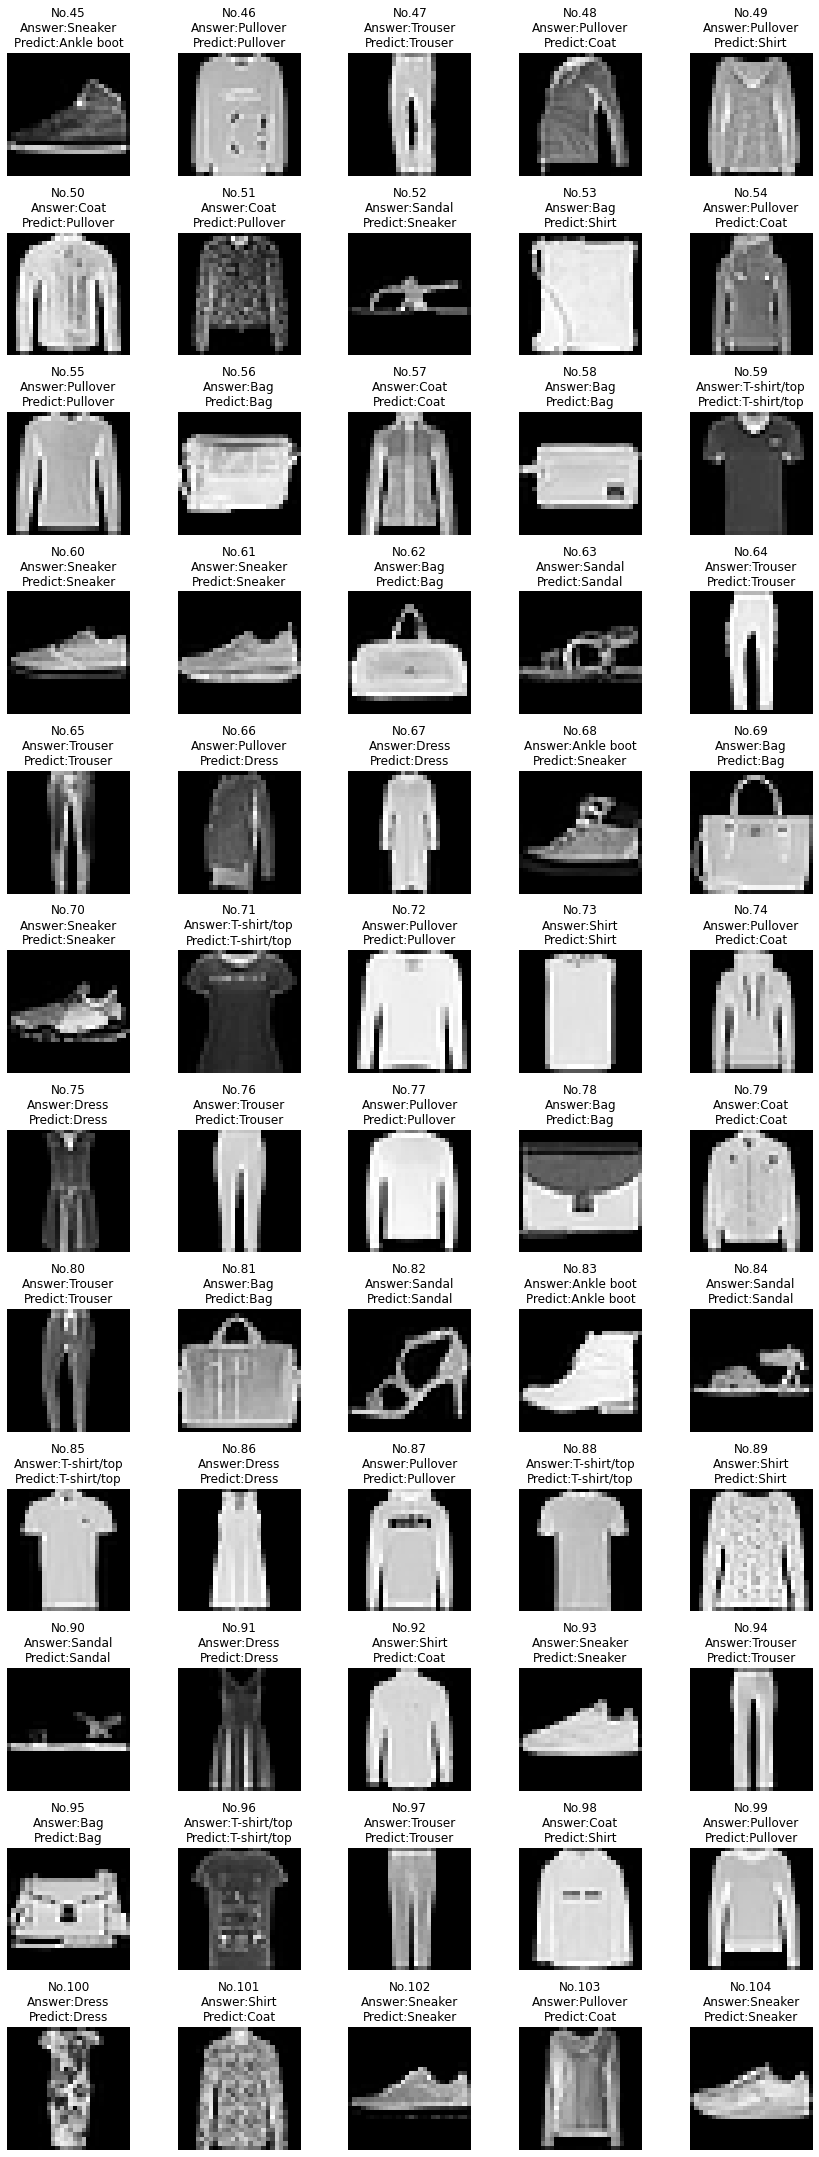

In [33]:
show_examples(model, test, device)

In [44]:
## Find three bugs in this model definition
class MLP3Wrong(Chain):

    def __init__(self):
        super(MLP3Wrong, self).__init__()
        with self.init_scope():
            self.l1=L.Linear(784, 200)#ミス時にはここが748になっていた
            self.l2=L.Linear(200, 200)
            self.l3=L.Linear(200, 10)

    def forward(self, x):
        h1 = F.tanh(self.l1(x))
        h2 = F.tanh(self.l2(h1))#ミス時にはh1がxになっていた
        y = self.l3(h2)#ミス時にはh1がh3になっていた
        return y

In [45]:
device = 0
n_epoch = 5
batchsize = 256

model = MLP3Wrong()
classifier_model = L.Classifier(model)
optimizer = optimizers.SGD()
train_and_validate(
    classifier_model, optimizer, train, validation, n_epoch, batchsize, device)

epoch       main/loss   main/accuracy  val/main/loss  val/main/accuracy  elapsed_time
1           1.41296     0.598394       1.00008        0.68291            1.69221       
2           0.866181    0.719351       0.794537       0.727246           3.5028        
3           0.731251    0.754187       0.705454       0.754883           5.3292        
4           0.6619      0.774514       0.652153       0.772852           7.20682       
5           0.616042    0.791266       0.614774       0.787109           9.03471       


https://chainer-colab-notebook.readthedocs.io/ja/latest/notebook/hands_on/chainer/begginers_hands_on/00_How_to_use_chainer_on_colaboratory.html

には、自分で課題をやってみましょうとあるので、そっちもコツコツやってみましょう